In [1]:
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import uproot
import utils
import yaml
from tensorflow import keras
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F


2023-03-21 10:39:52.147013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 10:39:53.880225: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/pkgs/cudnn-8.1.0.77-h90431f1_0/lib/:/opt/conda/pkgs/cudatoolkit-11.2.2-he111cf0_8/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-21 10:39:53.880380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_L

In [2]:
with open('definitions_image.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']


In [4]:
def keras_to_torch(X, y):
    X_torch = torch.tensor(X.transpose(0, 3, 1, 2), dtype=torch.float32)
    y_torch = torch.tensor(y, dtype=torch.long)
    return X_torch, y_torch

In [5]:
feature_array, y, spec_array = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root', features, spectators, labels, remove_mass_pt_window=False, entry_stop=500)
# make image
X = utils.make_image(feature_array)
# image is a 4D tensor (n_samples, n_pixels_x, n_pixels_y, n_channels)
X_train, y_train = keras_to_torch(X, y)

In [6]:
# load testing file
feature_array_test, label_array_test, spec_array_test = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root', features, spectators, labels, remove_mass_pt_window=False, entry_stop=250)


In [7]:
# make image
X_test = utils.make_image(feature_array_test)
X_test, y_test = keras_to_torch(X_test, label_array_test)

In [8]:
def conv_output_size(input_size, kernel_size, stride, padding):
    return (input_size - kernel_size + 2 * padding) // stride + 1

In [9]:
# TODO: check numbers in arguments
class CNNModel(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(CNNModel, self).__init__()
        
        print(input_shape)
        self.conv1 = nn.Conv2d(input_shape[0], 128, kernel_size=7, stride=2, padding=3)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.lrn1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=1)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.lrn2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Inception modules
        self.inc1 = Inception_Module(64, 'inc1')
        self.inc2 = Inception_Module(256, 'inc2')
        
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # More inception modules
        self.inc3 = Inception_Module(256, 'inc3')
        
        self.pool4 = nn.AdaptiveAvgPool2d((1, 1))
        self.softmax = nn.Softmax(dim=1)
        self.fc = nn.Linear(256, num_classes)  # Adjust the input size according to the output of the previous layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.lrn1(x)

        x = self.conv2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.lrn2(x)
        x = self.pool2(x)

        # Inception modules
        x = self.inc1(x)
        x = self.inc2(x)

        x = self.pool3(x)

        # More inception modules
        x = self.inc3(x)

        x = self.pool4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        #x = self.softmax(x)  # Add this line

        return x

In [10]:
class Inception_Module(nn.Module):
    def __init__(self, in_channels, name):
        super(Inception_Module, self).__init__()
        
        self.conv_a1 = nn.Conv2d(in_channels, 64, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_a1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_b1 = nn.Conv2d(in_channels, 96, kernel_size=1)
        nn.init.kaiming_normal_(self.conv_b1.weight, mode='fan_out', nonlinearity='relu')
        self.conv_c1 = nn.Conv2d(in_channels, 16, kernel_size=1)
        self.pool_d1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.conv_b2 = nn.Conv2d(96, 128, kernel_size=3, padding=1)
        self.conv_c2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.conv_d2 = nn.Conv2d(in_channels, 32, kernel_size=1)

    def forward(self, x):
        a1 = F.relu(self.conv_a1(x))
        b1 = F.relu(self.conv_b1(x))
        c1 = F.relu(self.conv_c1(x))
        d1 = F.relu(self.pool_d1(x))
        
        b2 = F.relu(self.conv_b2(b1))
        c2 = F.relu(self.conv_c2(c1))
        d2 = F.relu(self.conv_d2(d1))

        output = torch.cat((a1, b2, c2, d2), dim=1)
        return output

In [31]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device

    def train(self, epochs, learning_rate):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9)

        for epoch in range(epochs):
            running_loss = 0.0
            for i, data in enumerate(self.train_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                _, labels = torch.max(labels, dim=1)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
            print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

    def test(self):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Accuracy: %d %%' % (100 * correct / total))
        
    
    def plot_roc_curve(self):
        num_classes = 2
        y_true = []
        y_scores = []
        
        self.model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                
                y_true.extend(labels.cpu().numpy())
                y_scores.extend(probs.cpu().numpy())
        
        y_true = np.vstack(y_true)
        y_scores = np.vstack(y_scores)

        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC curve for each class
        for i in range(num_classes):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (Class {i})')
            plt.legend(loc="lower right")
            plt.show()

In [25]:
from torch.utils.data import Dataset, DataLoader

class Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [26]:
train_dataset = Data(X_train, y_train)
test_dataset = Data(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2)

input_shape = X_train.shape[1:]
num_classes = len(labels)

In [27]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [28]:
torch.cuda.empty_cache()


In [33]:
# Instantiate the model and trainer
model = CNNModel(train_dataset[0][0].shape, num_classes=num_classes)
trainer = Trainer(model, train_loader, test_loader, device)

torch.Size([1, 224, 224])


In [32]:
# Train and test the model
trainer.train(epochs=25, learning_rate=0.001)
#trainer.test()

Epoch 1, Loss: 1.9354357570409775
Epoch 2, Loss: 1.8312272876501083
Epoch 3, Loss: 1.6772497594356537
Epoch 4, Loss: 1.4793083220720291
Epoch 5, Loss: 1.1708481833338737
Epoch 6, Loss: 0.8174202367663383
Epoch 7, Loss: 0.665069792419672
Epoch 8, Loss: 0.5523048490285873
Epoch 9, Loss: 0.46538120321929455
Epoch 10, Loss: 0.4375285590067506
Epoch 11, Loss: 0.441842008382082
Epoch 12, Loss: 0.44557417556643486
Epoch 13, Loss: 0.41439931839704514
Epoch 14, Loss: 0.4254941828548908
Epoch 15, Loss: 0.41922878101468086
Epoch 16, Loss: 0.41463055461645126
Epoch 17, Loss: 0.46636074781417847
Epoch 18, Loss: 0.4097461514174938
Epoch 19, Loss: 0.4086988605558872
Epoch 20, Loss: 0.3880666047334671
Epoch 21, Loss: 0.3871452994644642
Epoch 22, Loss: 0.3679882977157831
Epoch 23, Loss: 0.40506889298558235
Epoch 24, Loss: 0.3679829239845276
Epoch 25, Loss: 0.4024294652044773


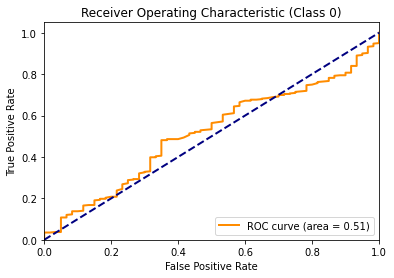

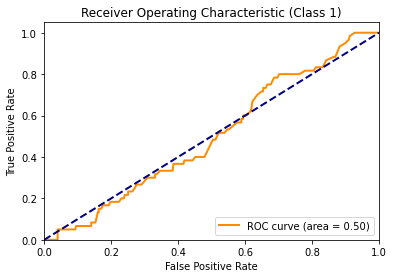

In [34]:
trainer.plot_roc_curve()